In [260]:
import pandas as pd
import vk
import time
import numpy as np
from datetime import datetime
import matplotlib
import seaborn as sns

session = vk.AuthSession('6212339', '89817730298', '162445mda618')
vk_api = vk.API(session)

pd.set_option('display.max_columns', 500)
%matplotlib inline

In [ ]:
#return 'code' parameter for VK API execute method
#Param
#users_id_list - bach of 25 users id

def get_user_friends_vk_code(users_id_list):
    code = 'return {'
    
    for id in users_id_list:
        code = '%s%s' % (code, '"%s": API.friends.get({"user_id":%s}),' % (id, id))
    
    code = '%s%s' % (code, '};')
        
    return code

#params:
#users_id_bach_list - list(bach-25(bach-1000))

def get_users_info_vk_codes(users_id_list):
    bach_100 = parts(list(map(lambda u: int(u), users_id_list)),100)
    bach_25 = parts(bach_100, 25)
    
    fields = "verified, sex, bdate, city, country, home_town, has_photo, domain, has_mobile, site, education, universities, schools, followers_count, common_count, occupation, nickname, relatives, relation, personal, connections, exports, activities, interests, music, movies, tv, books, games, about, quotes, is_hidden_from_feed, timezone, screen_name, maiden_name, career, military, blacklisted"
    
    code_list = []
    
    for bach in bach_25:
        code = 'return ['
    
        for users_ids in bach:
            users_ids_string = ",".join(list(map(lambda uid: str(uid) , users_ids)))
            code = '%s%s' % (code, 'API.users.get({"user_ids":"%s", "fields":"%s" }),' % (users_ids_string, fields))
        
        code = '%s%s' % (code, '];')
        
        code_list.append(code)
    
    return code_list

def parts(lst, n=25):
    return [lst[i:i + n] for i in iter(range(0, len(lst), n))]

def find_users(user_ids_list):
    
    users = []
    
    """
    users_batched_info = []
    
    codes = get_users_info_vk_codes(user_ids_list)
    
    for code in codes:
        try:
            users_info_exec = vk_api.execute(code=code, v=5.80)
            
            users_batched_info.extend(users_info_exec)
            
            time.sleep(2)
        except Exception as e:
            print(e)
            continue
            
    for bach in users_batched_info:
        users.extend(bach)
    """
    
    users_batches = parts(list(map(lambda u: int(u), user_ids_list)), 1000)
    fields = "sex, bdate, city, country, domain, has_mobile, site, followers_count, occupation, nickname"
    for batch in users_batches:
        try:
            res = vk_api.users.get(user_ids=batch, fields=fields, v=5.80)
            time.sleep(1)
        except Exception as e:
            print(e)
            continue
        
        users.extend(res)
    
    return users 

def get_users_friends(users_id_list):
    users_id_bachs = parts(users_id_list, 25)
    
    users_friends_dict = {}
    for bach in users_id_bachs:
        try:
            u_f_l = vk_api.execute(code=get_user_friends_vk_code(bach), v=5.80)
            
            time.sleep(1)
            
        except Exception as e:
            print(e)
            continue
        
        users_friends_dict.update(u_f_l)
    
    return users_friends_dict

In [283]:
#PARAMS:
cluster_num = 45


cluster_users_file_name = '../Data/ProcesData/users_from_' + str(cluster_num) + '_clusters.csv'
#Необходимо получить список друзей всех уникальных пользователей из кластера
users_from_cluster_df = pd.read_csv(cluster_users_file_name, encoding='windows-1251')

In [284]:
#find users info
users_list = find_users(users_from_cluster_df.uid.tolist())

users_info_list = pd.DataFrame(users_list)
users_info_list = users_info_list.rename(index=str, columns={"id": "uid"})

users_from_cluster_df = users_from_cluster_df[['uid']].merge(users_info_list, on='uid', how='inner')

In [285]:
#delete deactivated users
users_from_cluster_df['uid'] = users_from_cluster_df.uid.apply(lambda u: int(u))
users_from_cluster_df = users_from_cluster_df[users_from_cluster_df.deactivated.isnull()]

In [288]:
len(users_from_cluster_df)

13075

In [287]:
#postprocessing users_df
#age
def get_age(bdate):
    try:
        year = datetime.strptime(bdate, '%d.%m.%Y').year
        return datetime.today().year - year
    except Exception as e:
        return np.nan

ages = users_from_cluster_df.bdate.apply(get_age)
users_from_cluster_df['age'] = ages

def get_city_title(city):
    try:
        city_title = city['title']
        return city_title
    except Exception as e:
        return np.nan

users_from_cluster_df['city_title'] = users_from_cluster_df.city.apply(get_city_title)

def get_country_title(country):
    try:
        country_title = country['title']
        return country_title
    except Exception as e:
        return np.nan

users_from_cluster_df['country_title'] = users_from_cluster_df.country.apply(get_country_title)

def get_occupation_type(occupation):
    try:
        occupation_type = occupation['type']
        return occupation_type
    except Exception as e:
        return np.nan

users_from_cluster_df['occupation_type'] = users_from_cluster_df.occupation.apply(get_occupation_type)

def get_occupation_name(occupation):
    try:
        occupation_name = occupation['name']
        return occupation_name
    except Exception as e:
        return np.nan

users_from_cluster_df['occupation_name'] = users_from_cluster_df.occupation.apply(get_occupation_name)

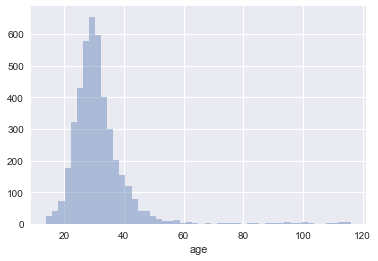

In [289]:
sns.distplot(users_from_cluster_df[~users_from_cluster_df.age.isnull()].age, kde=False)

In [293]:
users_from_cluster_df.occupation_name.value_counts()

СПбГУ                                                 318
СПбГЭУ                                                232
РГПУ им. А. И. Герцена                                196
СПбПУ Петра Великого (Политех)                        185
СПбГИК (бывш. СПбГУКИ)                                183
СЗИУ РАНХиГС (бывш. СЗАГС)                            101
СПбГУПТД (бывш. СПГУТД)                               100
МГУ                                                    78
ЛГУ им. А. С. Пушкина                                  68
СПбГУАП                                                66
СПбГТИ (ТУ)                                            60
СПбГИКиТ (бывш. СПбГУКиТ)                              60
ПГУПС Императора Александра I                          58
Университет ИТМО                                       51
Горный университет (бывш. СПГГУ)                       49
СПбГЭТУ (ЛЭТИ)                                         49
ТЭУ СПбПУ (бывш. СПбГТЭУ, СПбТЭИ)                      49
СПбГУВК       

In [291]:
#SAVE TO FILE WITH NAME users_from_N_cluster_info.csv
users_from_cluster_df.to_csv('../Data/ProcesData/users_from_' + str(cluster_num) + '_cluster_info.csv')

In [76]:
#get friends
users_friends = get_users_friends(users_from_cluster_df.uid.tolist())

In [87]:
uid_list = list(users_friends.keys())
friends_count = list(map(lambda u: u['count'], list(users_friends.values())))
friends_list = list(map(lambda u: u['items'], list(users_friends.values())))

In [88]:
users_friends_df = pd.DataFrame({'uid':uid_list, 'friends_count':friends_count, 'friends_list': friends_list})

In [278]:
users_friends_df.to_csv('../Data/ProcesData/users_from_' + str(cluster_num) +  '_cluster_friends.csv')

SyntaxError: invalid syntax (<ipython-input-278-56e85c0a5ff3>, line 1)

In [ ]:
""